### Source dataset: https://www.kaggle.com/datasets/gauravtopre/bank-customer-churn-dataset

In [16]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import lazy_pipeline as lpipe
from lazy_pipeline import df_info

# 1. Load data
Let's reduce the number of examples to 2000 for faster calculations

To assess the quality of forecasts, roc_auc, f1 is used, because for the dataset,  
both accuracy and completeness are important for evaluating customer churn.  
Accuracy is not suitable because the classes are not balanced

In [17]:
df = pd.read_csv('data/Bank Customer Churn Prediction.csv')
df.drop(['tenure', 'customer_id'], axis=1, inplace=True)

df = df.sample(2000, random_state=42).reset_index(drop=True)
df_info(df, 1)

Number of entries: 2000


,credit_score,country,gender,age,balance,products_number,credit_card,active_member,estimated_salary,churn
0,596,Germany,Male,32,96709.07,2,0,0,41788.37,0


Text(0.5, 1.0, 'Сlass balance')

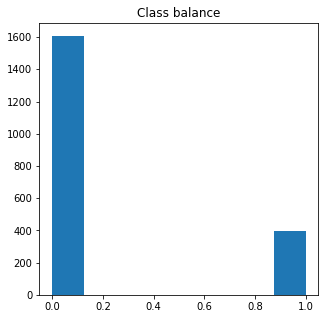

In [18]:
plt.figure(figsize=(5, 5))
plt.hist(df.churn, bins=8)
plt.title("Сlass balance")

In [19]:
cat_features = [
    'country', 'gender', 'products_number',
    'credit_card', 'active_member'
]
num_features = [
    'credit_score', 'age', 'estimated_salary'
]

label = 'churn'

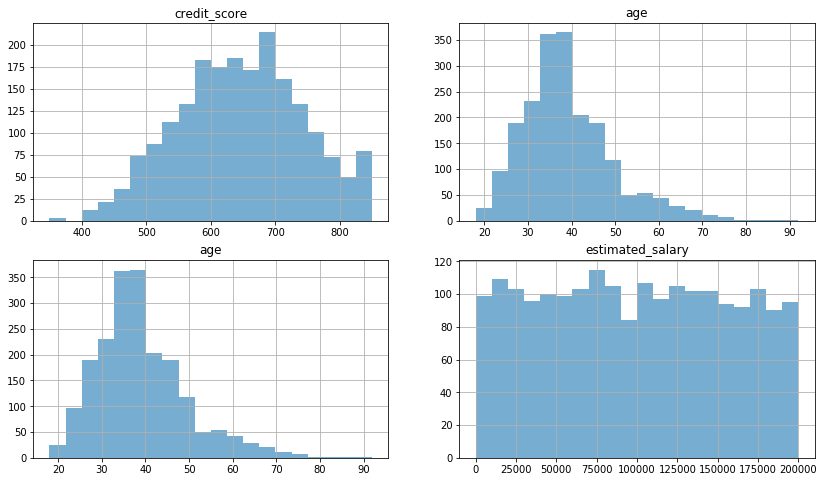

In [20]:
fig, ax = plt.subplots(2, 2, figsize=(14, 8) )
for i in range(2):
    for j in range(2):
        ax[i][j].grid()
        ax[i][j].hist(df[num_features[i+j]], alpha=0.6, bins=20)
        ax[i][j].set_title(num_features[i+j])

# 2. Binarize features
1) Categorical -  nominal scaling  
2) Numeric - ordinal scaling

- Nominal scaling is used to binarize categorical features

- Ordinal scaling is used to binarize numerical features.   
The numeric line of the attribute values is divided into intervals,  
if the value falls within the interval, then a label is placed in the corresponding column.

In [21]:
y = df[label].values.astype(bool)
X = df.drop(label, axis=1)

X_cat = lpipe.binarize_cat(X[cat_features])
X_num_1 = lpipe.binarize_num(X[['balance']], n_bins=2)
X_num_2= lpipe.binarize_num(X[num_features], n_bins=6)

X = pd.concat([X_cat, X_num_1, X_num_2], axis=1)
df_info(X)

Number of entries: 2000


,country: France,country: Germany,country: Spain,gender: Female,gender: Male,products_number: 1,products_number: 2,products_number: 3,products_number: 4,credit_card: 0,...,age_2,age_3,age_4,age_5,estimated_salary_0,estimated_salary_1,estimated_salary_2,estimated_salary_3,estimated_salary_4,estimated_salary_5
0,False,True,False,False,True,False,True,False,False,True,...,False,False,False,False,False,True,False,False,False,False


# 3. Solution
## 3.1 Base_line solving
### 3.1.1 Shuffle data

In [22]:
X_1 = X.sample(frac=1, random_state=40)  # Shuffle X
y_1 = y[X_1.index]

In [23]:
X_bin = [set(X_1.columns[x]) for idx, x in X_1.iterrows()]
X_bin[0]

{'active_member: 0',
 'age_1',
 'balance_0',
 'country: France',
 'credit_card: 1',
 'credit_score_1',
 'estimated_salary_2',
 'gender: Male',
 'products_number: 2'}

### 3.1.2 Train_test_split

In [24]:
n_train = int(len(X_1) * 0.3)
n_test = len(X_1) - n_train

y_test = y_1[n_train:]

n_train, n_test

(600, 1400)

### 3.1.3 Prediction

In [25]:
gen = lpipe.predict_array(X_bin, y_1, n_train, use_tqdm=True)
y_preds, t_preds = lpipe.apply_stopwatch(gen)

Predicting step by step:  30%|###       | 600/2000 [00:00<?, ?it/s]

In [26]:
%%time
gen = list(lpipe.predict_array(X_bin, y_1, n_train, use_tqdm=True, update_train=False))
y_preds_fixedtrain, t_preds_fixedtrain = lpipe.apply_stopwatch(gen)

Predicting step by step:  30%|###       | 600/2000 [00:00<?, ?it/s]

Wall time: 24.9 s


### 3.1.4 plot metrics

In [27]:
def get_scores(y_test: list, y_preds: list, y_preds_fixedtrain: list) -> dict:
    score_vals = {}
    for score_f in [accuracy_score, f1_score]:
        score_name = score_f.__name__
        preds = y_preds
        score_vals[score_name] = [score_f(y_test[:i], preds[:i]) for i in range(1, len(preds))]

        score_name = score_f.__name__ + '_fixedtrain'
        preds = y_preds_fixedtrain
        score_vals[score_name] = [score_f(y_test[:i], preds[:i]) for i in range(1, len(preds))]
    return score_vals

def plot_metrics(score_vals: dict, t_preds: list, t_preds_fixedtrain: list):
    N = range(n_train + 1, len(X))
    plt.figure(figsize=(14, 5))
    for score in score_vals:
        plt.plot(N, score_vals[score], label=score)
    plt.legend()
    plt.title('Metrics', size=14)
    plt.grid()

    N = range(n_train, len(X))
    plt.figure(figsize=(14, 4))
    plt.plot(N, t_preds, label='t_preds')
    plt.plot(N, t_preds_fixedtrain, label='t_preds_fixedtrain')
    plt.legend()
    plt.title('Time delays', size=14)
    plt.grid()

In [28]:
%%time
score_vals = get_scores(y_test, y_preds, y_preds_fixedtrain)
print(classification_report(y_test, y_preds))
roc_auc = round(roc_auc_score(y_test, y_preds), 4)
print(f'roc_auc_score: {roc_auc}')

              precision    recall  f1-score   support

       False       0.80      1.00      0.89      1119
        True       1.00      0.01      0.02       281

    accuracy                           0.80      1400
   macro avg       0.90      0.51      0.46      1400
weighted avg       0.84      0.80      0.72      1400

roc_auc_score: 0.5053
Wall time: 2.5 s


roc_auc is approximately equal to 0.5, which indicates the randomness of the predictions

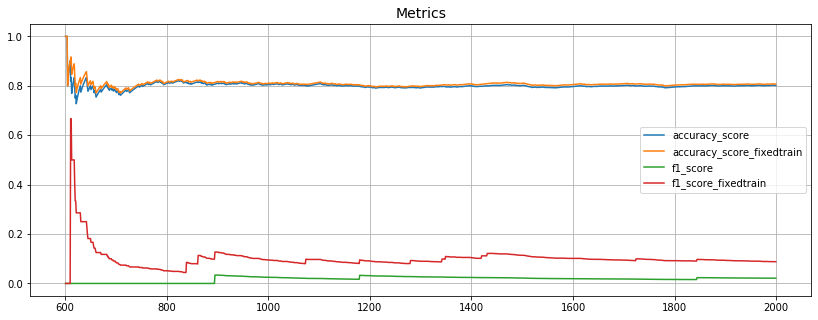

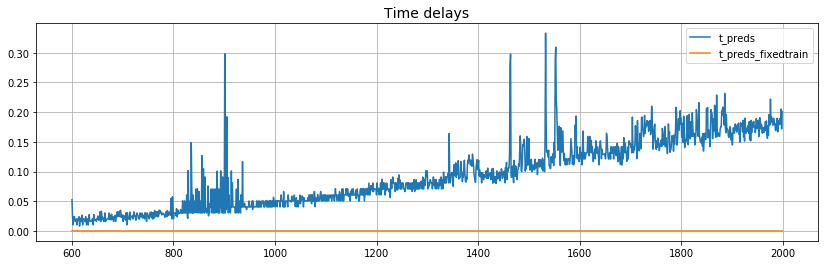

In [29]:
plot_metrics(score_vals, t_preds, t_preds_fixedtrain)

## 3.2 Imporoving solution

### 3.2.1 Better asymptotic time complexity

In [30]:
X_bin_2 = X_1.values
X_bin_2

array([[ True, False, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       ...,
       [False,  True, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False]])

In [31]:
gen = lpipe.predict_array_improved(X_bin_2, y_1, n_train, use_tqdm=True, 
                                   predict_func=lpipe.predict_with_generators_improved)
y_preds, t_preds = lpipe.apply_stopwatch(gen)

Predicting step by step:  30%|###       | 600/2000 [00:00<?, ?it/s]

In [32]:
gen = list(lpipe.predict_array_improved(X_bin_2, y_1, n_train, use_tqdm=True, update_train=False,
                                        predict_func=lpipe.predict_with_generators_improved))
y_preds_fixedtrain, t_preds_fixedtrain = lpipe.apply_stopwatch(gen)

Predicting step by step:  30%|###       | 600/2000 [00:00<?, ?it/s]

In [33]:
%%time
score_vals = get_scores(y_test, y_preds, y_preds_fixedtrain)
print(classification_report(y_test, y_preds))
roc_auc = round(roc_auc_score(y_test, y_preds), 4)
print(f'roc_auc_score: {roc_auc}')

              precision    recall  f1-score   support

       False       0.80      1.00      0.89      1119
        True       1.00      0.01      0.02       281

    accuracy                           0.80      1400
   macro avg       0.90      0.51      0.46      1400
weighted avg       0.84      0.80      0.72      1400

roc_auc_score: 0.5053
Wall time: 2.33 s


The accuracy have not changed, which indicates the correctness of the algorithm.  
However, the execution time has greatly decreased, because not all the signs are used to search for negative examples, but only those that were in intersection with positive ones.

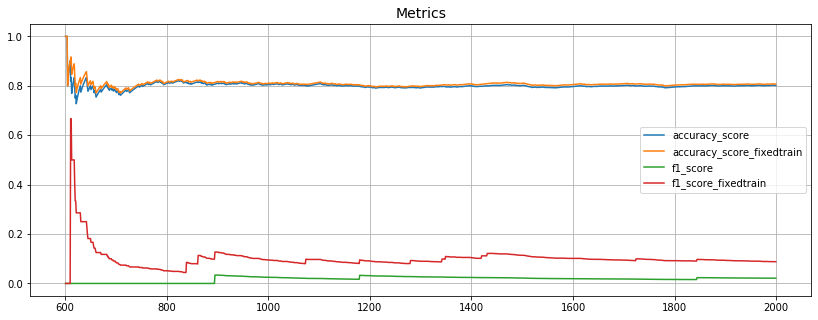

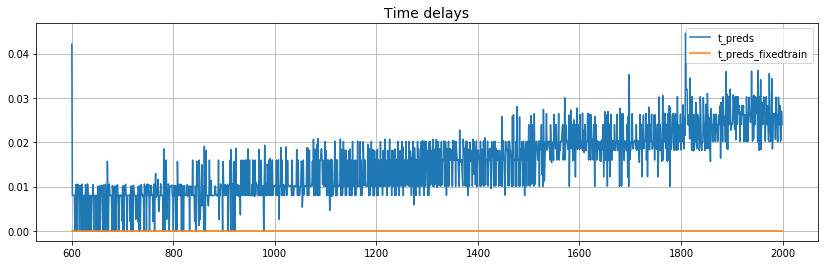

In [34]:
plot_metrics(score_vals, t_preds, t_preds_fixedtrain)

### 3.2.2 Modified algorithm

Instead of returning a Boolean value where there are more counterexamples,  
return the ratio of the normalized number of counterexamples

In [35]:
gen = lpipe.predict_array_improved(X_bin_2, y_1, n_train, use_tqdm=True,
                    predict_func=lpipe.predict_with_generators_modified)
y_preds, t_preds = lpipe.apply_stopwatch(gen)

Predicting step by step:  30%|###       | 600/2000 [00:00<?, ?it/s]

In [36]:
gen = lpipe.predict_array_improved(X_bin_2, y_1, n_train, use_tqdm=True, update_train=False, 
                    predict_func=lpipe.predict_with_generators_modified)
y_preds_fixedtrain, t_preds_fixedtrain = lpipe.apply_stopwatch(gen)

Predicting step by step:  30%|###       | 600/2000 [00:00<?, ?it/s]

In [37]:
%%time
threshold = 0.5
score_vals = get_scores(y_test, np.array(y_preds) > threshold,
                        np.array(y_preds_fixedtrain) > threshold)
print(classification_report(y_test, np.array(y_preds) > threshold))
roc_auc = round(roc_auc_score(y_test.astype(int), y_preds), 4)
print(f'roc_auc_score: {roc_auc}')

              precision    recall  f1-score   support

       False       0.84      0.95      0.89      1119
        True       0.59      0.27      0.37       281

    accuracy                           0.82      1400
   macro avg       0.71      0.61      0.63      1400
weighted avg       0.79      0.82      0.79      1400

roc_auc_score: 0.8004
Wall time: 1.81 s


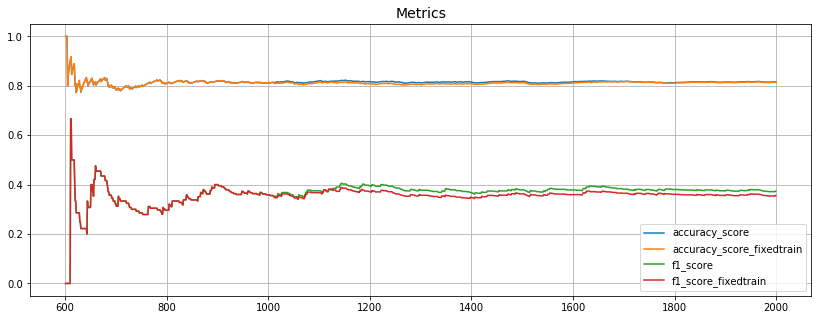

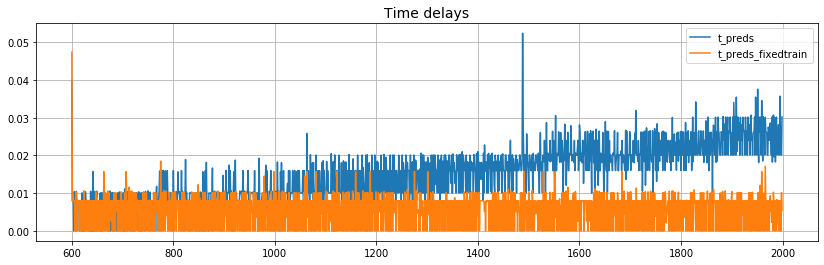

In [38]:
plot_metrics(score_vals, t_preds, t_preds_fixedtrain)

# 4. Evaluation of the impact on the execution time of intersection of the corresponding bitmasks instead of the intersection of sets
### 4.1 Intersection of sets

In [26]:
%%time
for x in X_bin:
    for x_temp in X_bin:
        x & x_temp
X_bin[0]

Wall time: 1.28 s


{'active_member: 0',
 'age_1',
 'balance_0',
 'country: France',
 'credit_card: 1',
 'credit_score_1',
 'estimated_salary_2',
 'gender: Male',
 'products_number: 2'}

### 4.2 Intersection of the corresponding bitmasks

In [27]:
%%time
for x in X_bin_2:
    for x_temp in X_bin_2:
        np.bitwise_and(x, x_temp)
X_bin_2[0]

Wall time: 2.16 s


array([ True, False, False, False,  True, False,  True, False, False,
       False,  True,  True, False,  True, False, False,  True, False,
       False, False, False, False,  True, False, False, False, False,
       False, False,  True, False, False, False])

### Conclusion: using bitmasks does not make the algorithm faster

# 5. Popular rule-based models
### 5.1 Catboost

In [28]:
from catboost import CatBoostClassifier

In [29]:
X_train, X_test = X_bin_2[:n_train], X_bin_2[n_train:]
y_train, y_test = y_1[:n_train].astype(int), y_1[n_train:].astype(int)

In [30]:
clf = CatBoostClassifier(iterations=200, max_depth=4, verbose=0)
clf.fit(X_train, y_train, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [31]:
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred))

roc_auc = round(roc_auc_score(y_test, y_pred_proba), 4)
print(f'roc_auc_score: {roc_auc}')

              precision    recall  f1-score   support

           0       0.86      0.96      0.91      1119
           1       0.69      0.38      0.49       281

    accuracy                           0.84      1400
   macro avg       0.77      0.67      0.70      1400
weighted avg       0.83      0.84      0.82      1400

roc_auc_score: 0.8252


### 5.2 Random Forest

In [32]:
from sklearn.ensemble import RandomForestClassifier

In [33]:
clf_2 = RandomForestClassifier(n_estimators=200, max_depth=8, verbose=0)
clf_2.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=8, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [34]:
y_pred = clf_2.predict(X_test)
y_pred_proba = clf_2.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred))

roc_auc = round(roc_auc_score(y_test, y_pred_proba), 4)
print(f'roc_auc_score: {roc_auc}')

              precision    recall  f1-score   support

           0       0.85      0.97      0.91      1119
           1       0.73      0.32      0.45       281

    accuracy                           0.84      1400
   macro avg       0.79      0.65      0.68      1400
weighted avg       0.83      0.84      0.82      1400

roc_auc_score: 0.8241


# Results:
1) Basic algorithm
- Metrics of the basic algorithm: `f1: 0.02`, `roc_auc: 0.51` - the quality is very low
- The execution time on 2000 examples with updating train: `2:03 min`

2) Improving the asymptotic complexity
- After improving the asymptotic complexity: the metrics have not changed (so the algorithm is correct)
- The execution time on the same examples with updating train: `20 s`

3) Modified algorithm
- Metrics after modification of the algorithm: `f1: 0.37`, `roc_auc: 0.80`

4) Using bitmasks does not make the algorithm faster

5) Popular solutions
- Metrics Catboost: `f1: 0.49`, `roc_auc: 0.825`
- Metrics RandomForest: `f1: 0.48`, `roc_auc: 0.824`

The execution time is much faster even than the improved algorithm `< 1 s`
